In [2]:
from __future__ import print_function
import sympy
import sympy.physics.mechanics as mech
sympy.init_printing()

In [3]:
rot_N, rot_E, rot_D, vel_N, vel_E, vel_D, \
    gyro_bias_N, gyro_bias_E, gyro_bias_D, accel_scale, \
    pos_N, pos_E, asl, terrain_asl, baro_bias, \
    wind_N, wind_E, wind_D, d, agl, phi, theta, psi  = sympy.symbols(
    'rot_N, rot_E, rot_D, vel_N, vel_E, vel_D, ' \
    'gyro_bias_N, gyro_bias_E, gyro_bias_D, accel_scale, ' \
    'pos_N, pos_E, asl, terrain_asl, baro_bias, ' \
    'wind_N, wind_E, wind_D, d, agl, phi, theta, psi') 
frame_i = mech.ReferenceFrame('i')
frame_n = frame_i.orientnew('n', 'Quaternion', (1, rot_N, rot_E, rot_D))
#frame_b = frame_n.orientnew('b', 'Quaternion', (q_0, q_1, q_2, q_3)) 
# easier to see where we get divide by zeros if we express dcm in euler angles
frame_b = frame_n.orientnew('b', 'Body', (psi, theta, phi), '321')
C_nb = frame_n.dcm(frame_b)
assert C_nb[0, 1] == frame_n.x.dot(frame_b.y)
sub_C_nb = {}
for i in range(3):
    for j in range(3):
        sub_C_nb[C_nb[i, j]] = sympy.Symbol('C_nb({:d}, {:d})'.format(i, j))
        sub_C_nb[-C_nb[i, j]] = -sympy.Symbol('C_nb({:d}, {:d})'.format(i, j))
sub_C_nb
sub_lin = {
    rot_N: 0,
    rot_E: 0,
    rot_D: 0,
    gyro_bias_N: 0,
    gyro_bias_E: 0,
    gyro_bias_D: 0
}
sub_agl = {
    asl - terrain_asl: agl
}
omega_bx, omega_by, omega_bz = sympy.symbols('omega_bx, omega_by, omega_bz')
flowX, flowY = sympy.symbols('flowX, flowY')
omega_ib_b = omega_bx * frame_b.x \
    + omega_by * frame_b.y \
    + omega_bz * frame_b.z
gyro_bias_i = gyro_bias_N * frame_i.x \
    + gyro_bias_E * frame_i.y \
    + gyro_bias_D * frame_i.z

In [4]:
xe = sympy.Matrix([rot_N, rot_E, rot_D, vel_N, vel_E, vel_D, gyro_bias_N, gyro_bias_E, gyro_bias_D,
                   pos_N, pos_E, asl, terrain_asl, baro_bias, wind_N, wind_E, wind_D])
xe.T

[rot_N  rot_E  rot_D  vel_N  vel_E  vel_D  gyro_bias_N  gyro_bias_E  gyro_bias
_D  pos_N  pos_E  asl  terrainₐₛₗ  baro_bias  wind_N  wind_E  wind_D]

In [5]:
def print_terms(terms):
    for t in terms:
        print('float {:s} = {:s};'.format(
                str(t[0]), str(t[1])))
        
def matrix_to_code(name, mat, i_name, i_syms, j_name, j_syms):
    print('Matrix<float, {:s}n, {:s}n> H;'.format(i_name, j_name))
    mat.simplify()
    terms, mat = sympy.cse(mat)
    print_terms(terms)
    mat = mat[0]
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if str(mat[i, j]) == "0":
                continue
            print('{:s}({:s}{:s}, {:s}{:s}) = {:s};'.format(
                str(name), i_name, str(i_syms[i]),
                j_name, str(j_syms[j]), str(mat[i, j])))

## Airspeed

In [6]:
wind_i = wind_N*frame_i.x + wind_E*frame_i.y + wind_D*frame_i.z
vel_i = vel_N*frame_i.x + vel_E*frame_i.y + vel_D*frame_i.z

In [7]:
rel_wind = wind_i - vel_i
y_airspeed = sympy.Matrix([rel_wind.dot(-frame_b.x)]).subs(sub_C_nb)
y_airspeed

⎡                  ⎛                                                          
⎣(-vel_D + wind_D)⋅⎝-C_nb(0, 0)⋅(2⋅rot_D⋅rot_N - 2⋅rot_E) - C_nb(1, 0)⋅(2⋅rot_

                                ⎛     2        2        2    ⎞⎞               
D⋅rot_E + 2⋅rot_N) - C_nb(2, 0)⋅⎝rot_D  - rot_E  - rot_N  + 1⎠⎠ + (-vel_E + wi

      ⎛                                                   ⎛       2        2  
nd_E)⋅⎝-C_nb(0, 0)⋅(2⋅rot_D + 2⋅rot_E⋅rot_N) - C_nb(1, 0)⋅⎝- rot_D  + rot_E  -

      2    ⎞                                       ⎞                     ⎛    
 rot_N  + 1⎠ - C_nb(2, 0)⋅(2⋅rot_D⋅rot_E - 2⋅rot_N)⎠ + (-vel_N + wind_N)⋅⎝- C_

         ⎛       2        2        2    ⎞                                     
nb(0, 0)⋅⎝- rot_D  - rot_E  + rot_N  + 1⎠ - C_nb(1, 0)⋅(-2⋅rot_D + 2⋅rot_E⋅rot

                                          ⎞⎤
_N) - C_nb(2, 0)⋅(2⋅rot_D⋅rot_N + 2⋅rot_E)⎠⎦

In [8]:
H_airspeed = y_airspeed.jacobian(xe).subs(sub_lin)
H_airspeed.T

⎡-2⋅C_nb(1, 0)⋅(-vel_D + wind_D) + 2⋅C_nb(2, 0)⋅(-vel_E + wind_E)⎤
⎢                                                                ⎥
⎢2⋅C_nb(0, 0)⋅(-vel_D + wind_D) - 2⋅C_nb(2, 0)⋅(-vel_N + wind_N) ⎥
⎢                                                                ⎥
⎢-2⋅C_nb(0, 0)⋅(-vel_E + wind_E) + 2⋅C_nb(1, 0)⋅(-vel_N + wind_N)⎥
⎢                                                                ⎥
⎢                           C_nb(0, 0)                           ⎥
⎢                                                                ⎥
⎢                           C_nb(1, 0)                           ⎥
⎢                                                                ⎥
⎢                           C_nb(2, 0)                           ⎥
⎢                                                                ⎥
⎢                               0                                ⎥
⎢                                                                ⎥
⎢                               0                             

In [9]:
matrix_to_code('H', H_airspeed,
               'Y_airspeed::', [sympy.Symbol('airspeed')],
               'Xe::', xe)

Matrix<float, Y_airspeed::n, Xe::n> H;
float x0 = 2*C_nb(1, 0);
float x1 = vel_D - wind_D;
float x2 = 2*C_nb(2, 0);
float x3 = vel_E - wind_E;
float x4 = 2*C_nb(0, 0);
float x5 = vel_N - wind_N;
H(Y_airspeed::airspeed, Xe::rot_N) = x0*x1 - x2*x3;
H(Y_airspeed::airspeed, Xe::rot_E) = -x1*x4 + x2*x5;
H(Y_airspeed::airspeed, Xe::rot_D) = -x0*x5 + x3*x4;
H(Y_airspeed::airspeed, Xe::vel_N) = C_nb(0, 0);
H(Y_airspeed::airspeed, Xe::vel_E) = C_nb(1, 0);
H(Y_airspeed::airspeed, Xe::vel_D) = C_nb(2, 0);
H(Y_airspeed::airspeed, Xe::wind_N) = -C_nb(0, 0);
H(Y_airspeed::airspeed, Xe::wind_E) = -C_nb(1, 0);
H(Y_airspeed::airspeed, Xe::wind_D) = -C_nb(2, 0);


## Distance

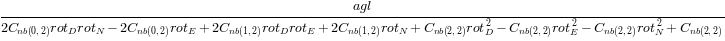

In [10]:
d_eq = sympy.solve((d*frame_b.z).dot(frame_i.z).subs(sub_C_nb) - (asl - terrain_asl), d)[0]
d_eq.subs(sub_agl)

In [11]:
y_dist = sympy.Matrix([d_eq]).subs(sub_C_nb)
y_dist[0].subs(sub_lin).subs(sub_agl)

In [12]:
xe.T

[rot_N  rot_E  rot_D  vel_N  vel_E  vel_D  gyro_bias_N  gyro_bias_E  gyro_bias
_D  pos_N  pos_E  asl  terrainₐₛₗ  baro_bias  wind_N  wind_E  wind_D]

In [13]:
H_distance = y_dist.jacobian(xe).subs(sub_lin).subs(sub_agl)
H_distance.T
matrix_to_code('H', H_distance, 'Y_distance_down::',
               [sympy.symbols('d')], 'Xe::', xe)

Matrix<float, Y_distance_down::n, Xe::n> H;
float x0 = 2*agl/C_nb(2, 2)**2;
float x1 = 1/C_nb(2, 2);
H(Y_distance_down::d, Xe::rot_N) = -C_nb(1, 2)*x0;
H(Y_distance_down::d, Xe::rot_E) = C_nb(0, 2)*x0;
H(Y_distance_down::d, Xe::asl) = x1;
H(Y_distance_down::d, Xe::terrain_asl) = -x1;


## Optical Flow

In [68]:
y_flow_sym = [flowX, flowY]
omega_b = (omega_ib_b - gyro_bias_i).express(frame_b)

In [73]:
vel_f_b = -vel_i - omega_b.cross(d_eq*frame_b.z)
y_flow = sympy.Matrix([
    vel_f_b.dot(frame_b.y)/d_eq,
    vel_f_b.dot(frame_b.x)/d_eq,
    ]).subs(sub_C_nb)

In [81]:
y_flow_lin = y_flow.subs(sub_lin).subs(sub_agl).subs(sub_C_nb)
y_flow_lin.simplify()
y_flow_lin

⎡ -C_nb(2, 2)⋅(C_nb(0, 1)⋅vel_N + C_nb(1, 1)⋅vel_E + C_nb(2, 1)⋅vel_D) + agl⋅ω
⎢ ────────────────────────────────────────────────────────────────────────────
⎢                                       agl                                   
⎢                                                                             
⎢-(C_nb(2, 2)⋅(C_nb(0, 0)⋅vel_N + C_nb(1, 0)⋅vel_E + C_nb(2, 0)⋅vel_D) + agl⋅ω
⎢─────────────────────────────────────────────────────────────────────────────
⎣                                       agl                                   

_bx  ⎤
───  ⎥
     ⎥
     ⎥
_by) ⎥
─────⎥
     ⎦

In [82]:
H_flow = y_flow.jacobian(xe).subs(sub_lin).subs(sub_agl)
matrix_to_code('H', H_flow, 'Y_flow::', y_flow_sym, 'Xe::', xe)

Matrix<float, Y_flow::n, Xe::n> H;
float x0 = 1/agl;
float x1 = 2*C_nb(1, 2);
float x2 = C_nb(0, 1)*vel_N;
float x3 = C_nb(1, 1)*vel_E;
float x4 = 2*C_nb(2, 2)*vel_D;
float x5 = C_nb(2, 1)*vel_D;
float x6 = 2*C_nb(2, 2)*vel_E;
float x7 = 2*x0;
float x8 = C_nb(2, 2)*vel_D;
float x9 = C_nb(2, 2)*vel_N;
float x10 = 2*C_nb(2, 2)*x0;
float x11 = C_nb(2, 2)*x0;
float x12 = C_nb(2, 2)/agl**2;
float x13 = x12*(x2 + x3 + x5);
float x14 = C_nb(0, 0)*vel_N;
float x15 = C_nb(1, 0)*vel_E;
float x16 = C_nb(2, 0)*vel_D;
float x17 = x12*(x14 + x15 + x16);
H(Y_flow::flowX, Xe::rot_N) = x0*(-C_nb(1, 1)*x4 + C_nb(2, 1)*x6 - x1*x2 - x1*x3 - x1*x5);
H(Y_flow::flowX, Xe::rot_E) = x7*(C_nb(0, 1)*x8 + C_nb(0, 2)*x2 + C_nb(0, 2)*x3 + C_nb(0, 2)*x5 - C_nb(2, 1)*x9);
H(Y_flow::flowX, Xe::rot_D) = -x10*(C_nb(0, 1)*vel_E - C_nb(1, 1)*vel_N);
H(Y_flow::flowX, Xe::vel_N) = -C_nb(0, 1)*x11;
H(Y_flow::flowX, Xe::vel_E) = -C_nb(1, 1)*x11;
H(Y_flow::flowX, Xe::vel_D) = -C_nb(2, 1)*x11;
H(Y_flow::flowX, Xe::gyro_bias_N) 